In [27]:
import os;import sys; sys.path.append('../../DataPreparation')
from cleaner import read_data
from helpers import convey_insights,display_with_scroll
sys.path.append("../../")
from utils import save_model,save_hyperparameters,load_hyperparameters,nice_table
from ModelPipelines.ModelAnalysis import evaluate, learning_curves,cross_validation,log_weights_analysis
from mlpath import mlquest as mlq
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import xgboost as xgb

In [28]:
model_name= 'Xgboost'
model_adjusted_name= model_name
mlq.start_quest(model_name, table_dest="../../", log_defs=True)

# <font color="aqua">Xgboost </font> Model

###  Read the Data

In [29]:
x_data, y_data,_,_ = mlq.l(read_data)(split="train", nulls="mix",outliers="cap", standardize="standardize",encode='Binary',pca=0.9,skip=['RetentionCalls','RetentionOffersAccepted'], oversample='None')

### Default values of HyperParameters

In [30]:
nice_table(xgb.XGBClassifier().get_params())

objective,use_label_encoder,base_score,booster,callbacks,colsample_bylevel,colsample_bynode,colsample_bytree,early_stopping_rounds,enable_categorical,eval_metric,feature_types,gamma,gpu_id,grow_policy,importance_type,interaction_constraints,learning_rate,max_bin,max_cat_threshold,max_cat_to_onehot,max_delta_step,max_depth,max_leaves,min_child_weight,missing,monotone_constraints,n_estimators,n_jobs,num_parallel_tree,predictor,random_state,reg_alpha,reg_lambda,sampling_method,scale_pos_weight,subsample,tree_method,validate_parameters,verbosity
binary:logistic,None,None,None,None,None,None,None,None,False,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,nan,None,100,None,None,None,None,None,None,None,None,None,None,None,None


### Search Best Hyper Parameters

In [31]:
if os.path.exists(f"../../Saved/{model_adjusted_name}_opt_params.pkl") :
    opt_params=load_hyperparameters(model_adjusted_name)
    
else:
    model=mlq.l(xgb.XGBClassifier)(use_label_encoder=False, eval_metric='logloss')
    params = {
        "n_estimators": [10, 50, 100, 200],
        "max_depth": [3, 6, 9, 12],
        "learning_rate": [0.01, 0.1, 0.2, 0.3],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "gamma": [0, 0.1, 0.2, 0.3],
        "reg_alpha": [0, 0.1, 0.5, 1],
        "reg_lambda": [1, 1.5, 2],
        "scale_pos_weight": [1, 2, 3]
    }

    model = RandomizedSearchCV(model, params, n_iter=10, cv=5, verbose=3, n_jobs=-1,scoring="f1")
    model.fit(x_data, y_data)

    opt_params = model.best_params_
    save_hyperparameters(model_adjusted_name, opt_params)

In [32]:
nice_table(opt_params)

subsample,scale_pos_weight,reg_lambda,reg_alpha,n_estimators,max_depth,learning_rate,gamma,colsample_bytree
0.8,3,2,0.5,100,3,0.01,0,1.0


### Train Model

In [33]:
model = mlq.l(xgb.XGBClassifier)(**opt_params)
model.fit(x_data,y_data)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Evaluate Model

In [34]:
y_pred=model.predict(x_data)
metrics=evaluate(y_pred=y_pred, y_true=y_data,title="Train Evaluation Metrics", table=True)

Accuracy,Precision,Recall,F1 Score,ROC AUC
0.52565,0.35234,0.778,0.48502,0.60101


### Model Generalization

In [35]:
scores=cross_validation(model,x_data,y_data)
convey_insights([
   "We can see that the model has bad generalization as the training score is much higher than the validation score", 
])

Accuracy_train,Precision_train,Recall_train,F1 Score_train,ROC AUC_train
0.52561,0.35241,0.7787,0.48522,0.6481


Accuracy_test,Precision_test,Recall_test,F1 Score_test,ROC AUC_test
0.52271,0.34994,0.77228,0.48164,0.63978


<h3><font color="pink" size=5>Insights</font></h3> <font size=4>
<font color="pink">✦</font> We can see that the model has bad generalization as the training score is much higher than the validation score<br><br></font>

### Model Learning Curve

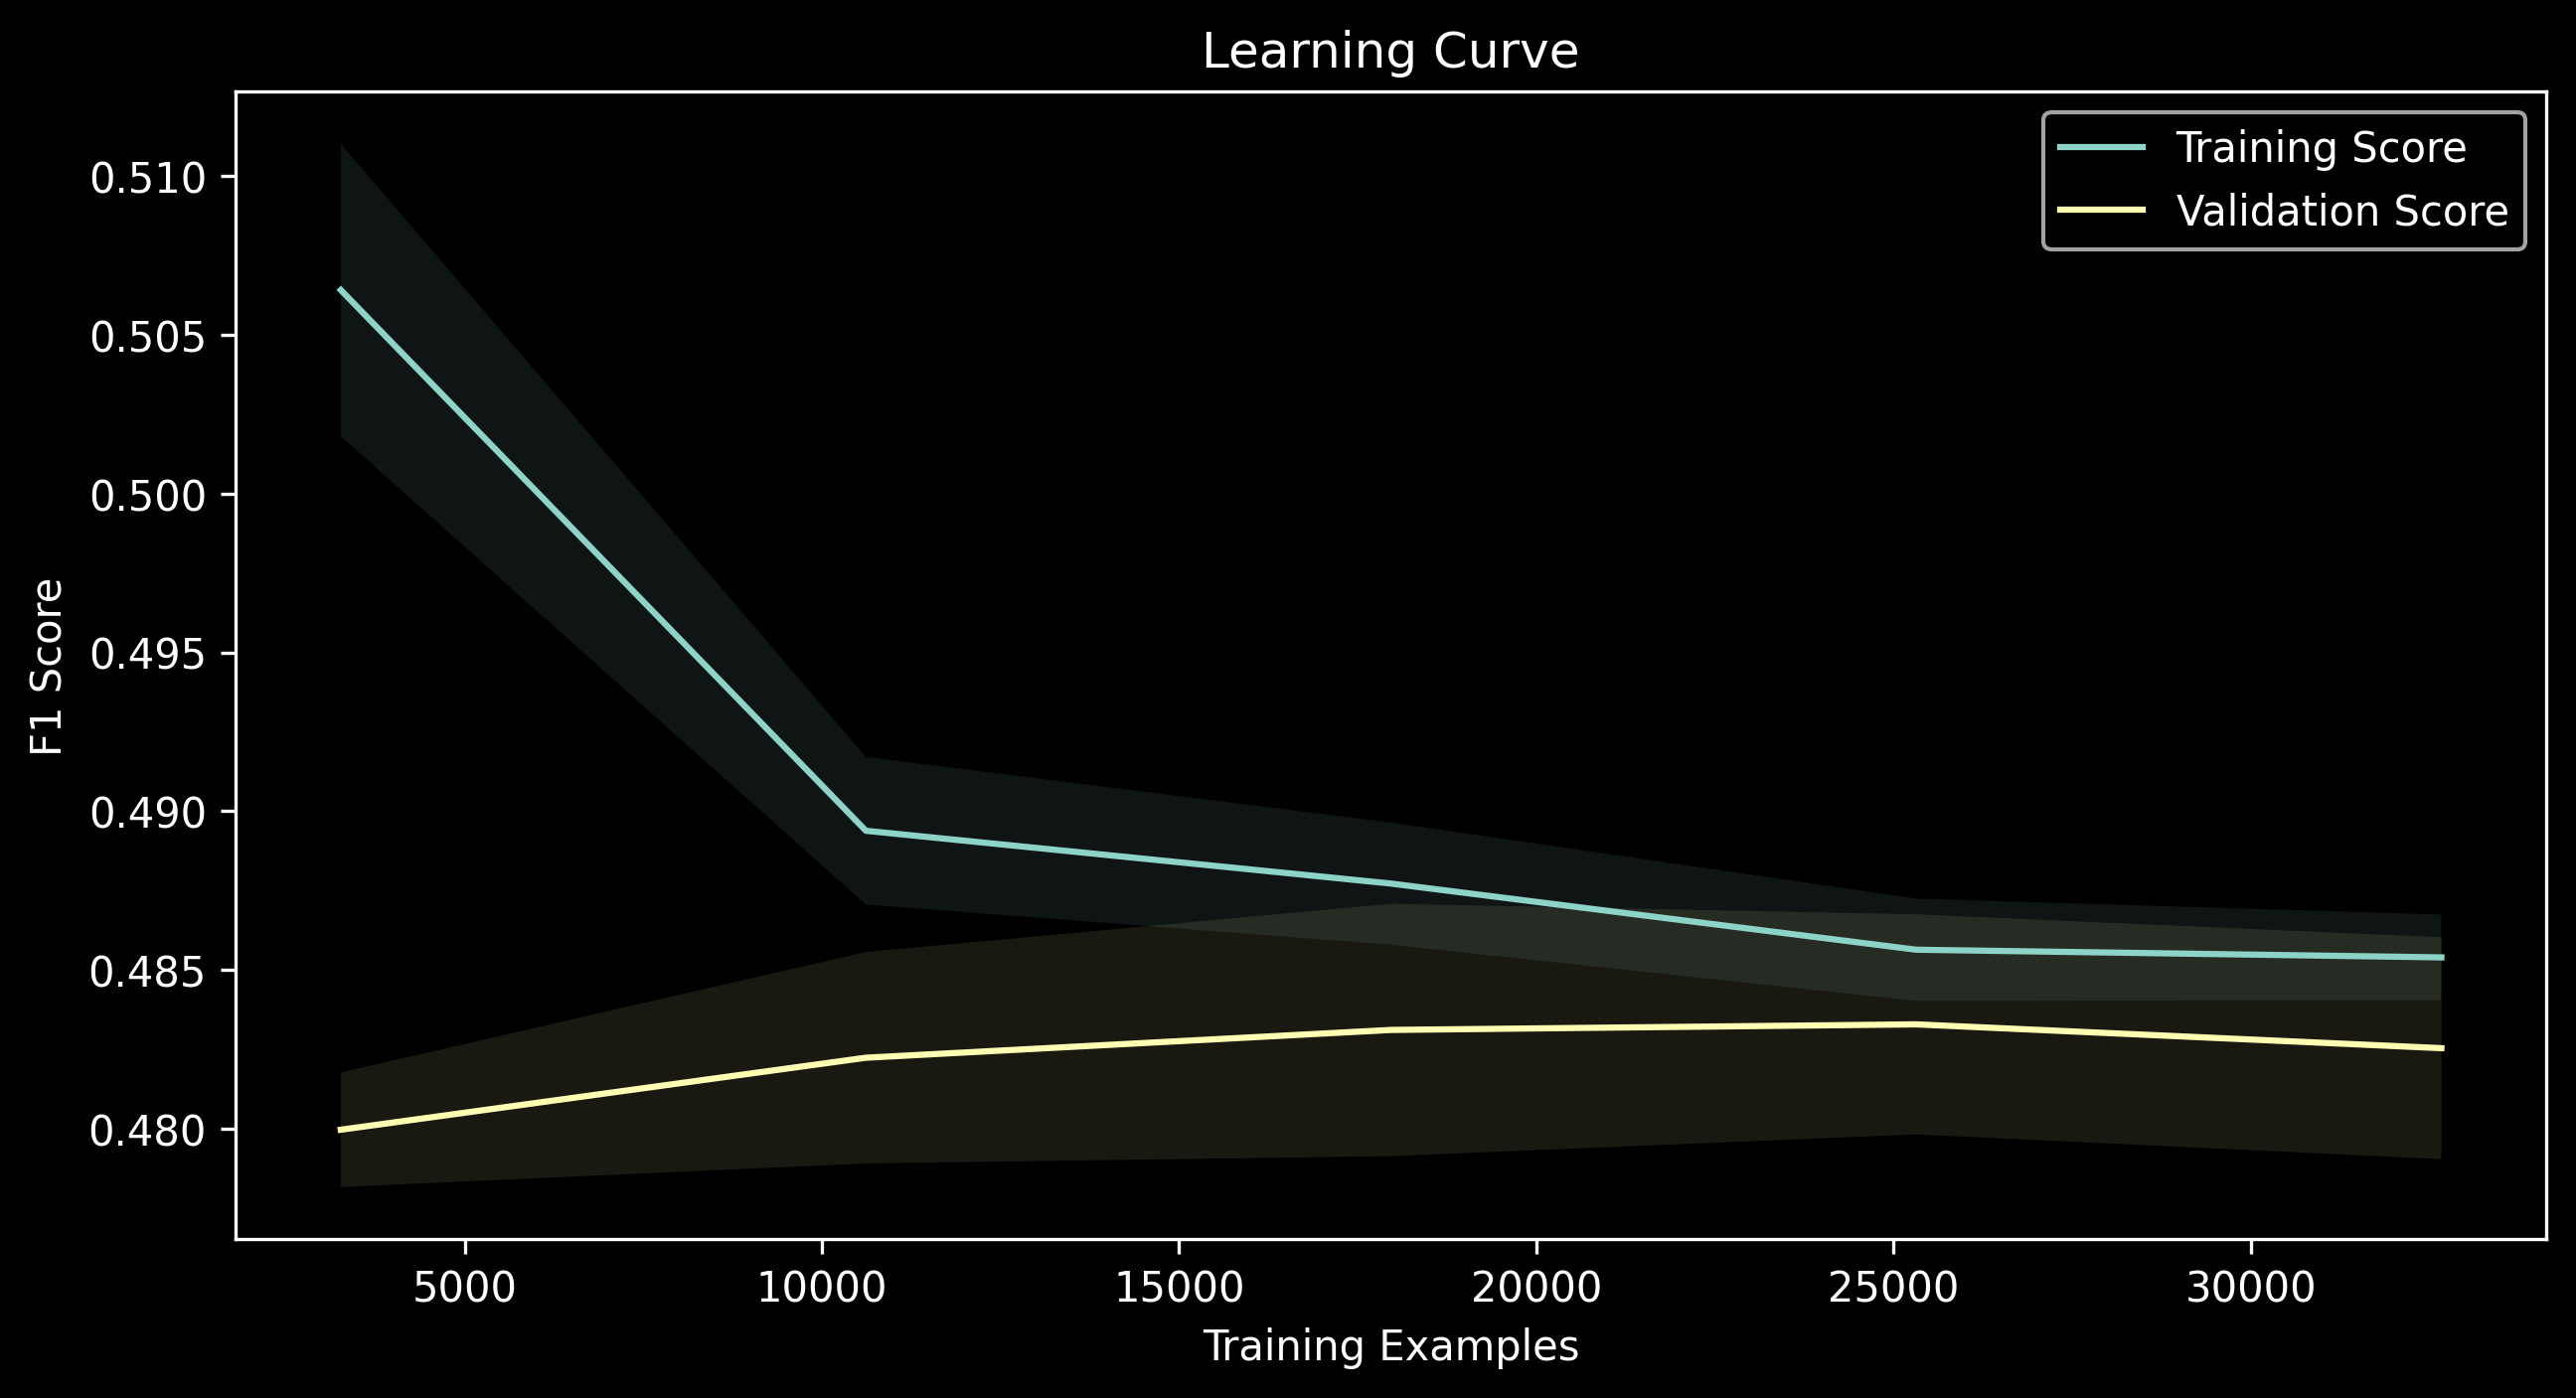

In [36]:
train_sizes = np.linspace(0.1, 1.0, 5)
learning_curves(model, x_data, y_data,N=train_sizes)

### Feature Selection

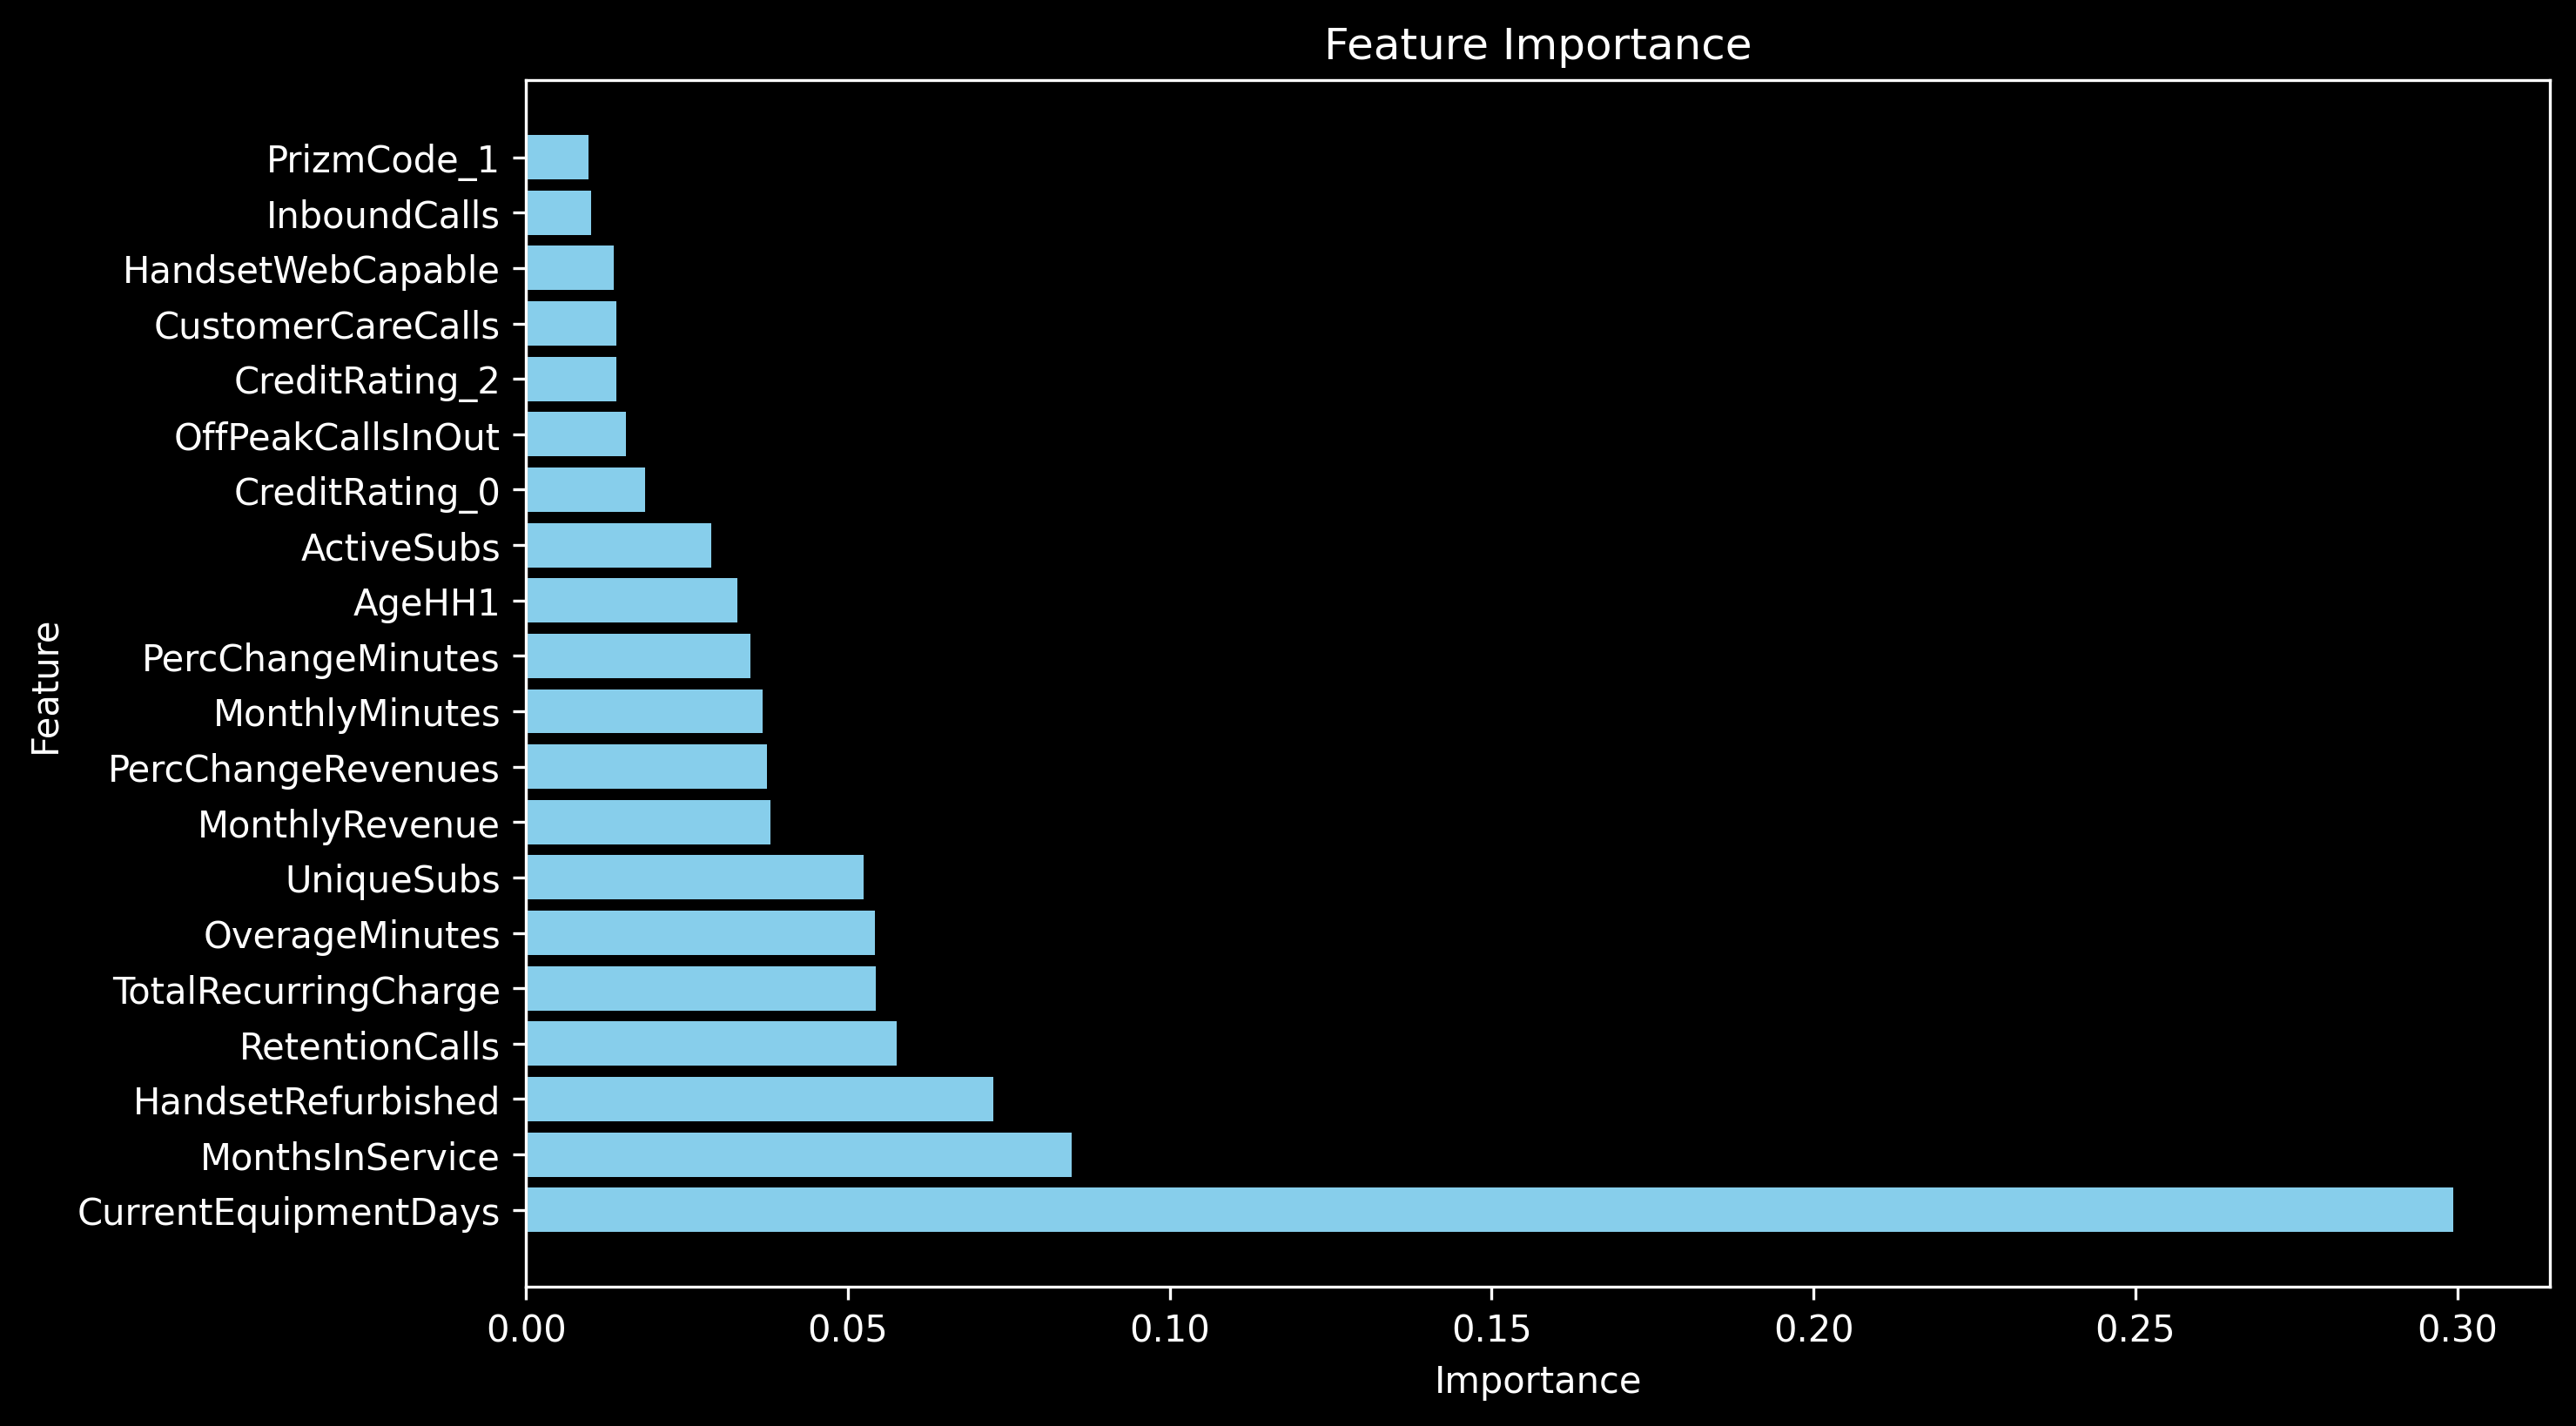

In [37]:
log_weights_analysis(model,x_data)


In [ ]:
convey_insights(['Has better feature importance than Gradient Boosting'])

### Save Model

In [38]:
save_model(model_adjusted_name, model)

### Tracking

In [39]:
mlq.log_metrics(**scores)
mlq.end_quest()
mlq.show_logs(model_name, table_dest="../../", last_k=10)

### Oversampling

In [43]:
# with oversampling

mlq.start_quest(model_name, table_dest="../../", log_defs=True)

x_train,x_val,y_train,y_val=mlq.l(read_data)(split="val", nulls="mix",outliers="cap", standardize="standardize",encode='Binary',pca=0.9,skip=['RetentionCalls','RetentionOffersAccepted'], oversample='none')

model = mlq.l(xgb.XGBClassifier)(**opt_params)
model.fit(x_train,y_train)

y_pred_train=model.predict(x_train)
y_pred_val=model.predict(x_val)

train_scores=evaluate(y_pred=y_pred_train, y_true=y_train,title="Train Evaluation Metrics", table=False)
val_scores=evaluate(y_pred=y_pred_val, y_true=y_val,title="Val Evaluation Metrics", table=False)

display(nice_table(train_scores,"Train Evaluation Metrics"))
display(nice_table(val_scores,"Val Evaluation Metrics"))
train_scores = {f"{key}_train": value for key, value in train_scores.items()}
val_scores = {f"{key}_test": value for key, value in val_scores.items()}


scores={**train_scores,**val_scores}
mlq.log_metrics(**scores)
mlq.end_quest()

Accuracy,Precision,Recall,F1 Score,ROC AUC
0.529,0.35497,0.77793,0.48749,0.60313


Accuracy,Precision,Recall,F1 Score,ROC AUC
0.51249,0.3414,0.77265,0.47356,0.59103


In [46]:
mlq.show_logs(model_name, table_dest="../../", last_k=10)

In [45]:
convey_insights([
    "results are better than the model without oversampling",
    "this model is the best so far in generalization "
])

<h3><font color="pink" size=5>Insights</font></h3> <font size=4>
<font color="pink">✦</font> results are better than the model without oversampling<br><br><font color="pink">✦</font> this model is the best so far in generalization <br><br></font>

### Results

In [49]:
x_train,y_train,_,_=read_data(split="train",oversample='none')
x_test,y_test,_,_=read_data(split="test", oversample='none')

opt_params['reg_alpha']=1
opt_params['n_estimators']=200
opt_params['learning_rate']=0.1
model=xgb.XGBClassifier(**opt_params)
model.fit(x_train,y_train)

y_pred_train=model.predict(x_train)
y_pred_test=model.predict(x_test)


metrics=evaluate(y_pred=y_pred_train, y_true=y_train,title="Train Evaluation Metrics", table=True)
metrics=evaluate(y_pred=y_pred_test, y_true=y_test,title="Test Evaluation Metrics", table=True)

Accuracy,Precision,Recall,F1 Score,ROC AUC
0.58697,0.3916,0.79215,0.52411,0.64824


Accuracy,Precision,Recall,F1 Score,ROC AUC
0.55455,0.37395,0.77595,0.50468,0.6195
